In [2]:
import cv2
import csv
import collections
import time
import numpy as np
from tracker import *

In [1]:
# TechVidvan Vehicle counting and Classification

# Import necessary packages

import cv2
import csv
import collections
import numpy as np
from tracker import *

# Initialize Tracker
tracker = EuclideanDistTracker()

# Cars Passed Images
cars_snapped = []

# Detection confidence threshold
confThreshold =0.2
nmsThreshold= 0.2

font_color = (100, 150, 255)
font_size = 0.5
font_thickness = 2

# Middle cross line position
middle_line_position = 225   
up_line_position = middle_line_position - 15
down_line_position = middle_line_position + 15


# Store Coco Names in a list
classesFile = "coco.names"
classNames = open(classesFile).read().strip().split('\n')
#print(classNames)
#print(len(classNames))

# class index for our required detection classes
required_class_index = [2, 3, 5, 7]

detected_classNames = []

## Model Files
modelConfiguration = 'yolov3-320.cfg'
modelWeigheights = 'yolov3-320.weights'

# configure the network model
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeigheights)


# Define random colour for each class
np.random.seed(40)
colors = np.random.randint(0, 255, size=(len(classNames), 3), dtype='uint8')

def get_snapshot(frame,x,y,w,h):
    img = frame.copy()
    crop_img = img[y:y+h, x:x+w]
    return crop_img

# Function for finding the center of a rectangle
def find_center(x, y, w, h):
    x1=int(w/2)
    y1=int(h/2)
    cx = x+x1
    cy=y+y1
    return cx, cy
    
# List for store vehicle count information
temp_up_list = []
temp_down_list = []
up_list = [0, 0, 0, 0]
down_list = [0, 0, 0, 0]
passed_list = []

# Function for count vehicle
def count_vehicle(box_id, img):
    x, y, w, h, id, index = box_id

    # Find the center of the rectangle for detection
    center = find_center(x, y, w, h)
    ix, iy = center

    if((id not in passed_list) and (((iy - middle_line_position )**2)<= 50)):
        passed_list.append(id)
        snap_shot = get_snapshot(img,x,y,w,h)
        cars_snapped.append(snap_shot)
        passed_list.append(id)

    # Draw circle in the middle of the rectangle
    cv2.circle(img, center, 2, (0, 0, 255), 1)  # end here
    # print(up_list, down_list)

# Function for finding the detected objects from the network output
def postProcess(outputs,img):
    global detected_classNames 
    height, width = img.shape[:2]
    boxes = []
    classIds = []
    confidence_scores = []
    detection = []
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if classId in required_class_index:
                if confidence > confThreshold:
                    # print(classId)
                    w,h = int(det[2]*width) , int(det[3]*height)
                    x,y = int((det[0]*width)-w/2) , int((det[1]*height)-h/2)
                    boxes.append([x,y,w,h])
                    classIds.append(classId)
                    confidence_scores.append(float(confidence))

    # Apply Non-Max Suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidence_scores, confThreshold, nmsThreshold)
    # print(classIds)
    for i in indices.flatten():
        
        x, y, w, h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
        if(y<400):
            continue
        # print(x,y,w,h)

        color = [int(c) for c in colors[classIds[i]]]
        name = classNames[classIds[i]]
        detected_classNames.append(name)
        # Draw classname and confidence score 
        cv2.putText(img,f'{name.upper()} {int(confidence_scores[i]*100)}%',
                  (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Draw bounding rectangle
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
        detection.append([x, y, w, h, required_class_index.index(classIds[i])])

    # Update the tracker for each object
    boxes_ids = tracker.update(detection)
    #print(np.shape(boxes_ids))
    for box_id in boxes_ids:
        count_vehicle(box_id, img)


def realTime(filename):
    global middle_line_position, up_line_position, down_line_position
    # Initialize the videocapture object
    cap = cv2.VideoCapture(filename)
    input_size = 320
    while True:
        success, img = cap.read()
        if not success:
            break
        #img = cv2.resize(img,(0,0),None,0.5,0.5)
        ih, iw, channels = img.shape
        middle_line_position = int(ih*3/4)
        up_line_position = middle_line_position - int(ih/15)
        down_line_position = middle_line_position + int(ih/15)
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (input_size, input_size), [0, 0, 0], 1, crop=False)

        # Set the input of the network
        net.setInput(blob)
        layersNames = net.getLayerNames()
        outputNames = [(layersNames[i - 1]) for i in net.getUnconnectedOutLayers()]
        # Feed data to the networkl
        outputs = net.forward(outputNames)
    
        # Find the objects from the network output
        postProcess(outputs,img)

        # Draw the crossing lines

        cv2.line(img, (0, middle_line_position), (iw, middle_line_position), (155, 30, 155), 1)
        cv2.line(img, (0, up_line_position), (iw, up_line_position), (0, 0, 255), 1)
        cv2.line(img, (0, down_line_position), (iw, down_line_position), (0, 0, 255), 1)

        # Draw counting texts in the frame
        cv2.putText(img, "Up", (110, 20), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Down", (160, 20), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Car:        "+str(up_list[0])+"     "+ str(down_list[0]), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Motorbike:  "+str(up_list[1])+"     "+ str(down_list[1]), (20, 60), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Bus:        "+str(up_list[2])+"     "+ str(down_list[2]), (20, 80), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Truck:      "+str(up_list[3])+"     "+ str(down_list[3]), (20, 100), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        cv2.putText(img, "Snapped:    "+str(len(cars_snapped)),                     (20, 120), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_color, font_thickness)
        # Show the frames
        cv2.imshow('Output', img)

        if cv2.waitKey(1) == ord('q'):
            break


    cap.release()
    cv2.destroyAllWindows()



if __name__ == '__main__':
    # realTime()
    filename = 'traffic_srinagarhighway_Islamabad_Police.mp4'
    filename = 'traffic_Islamabad_Police.mp4'
    realTime(filename)
    print(len(cars_snapped))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
80
25


In [32]:
print(len(cars_snapped[0][0][0]))

3


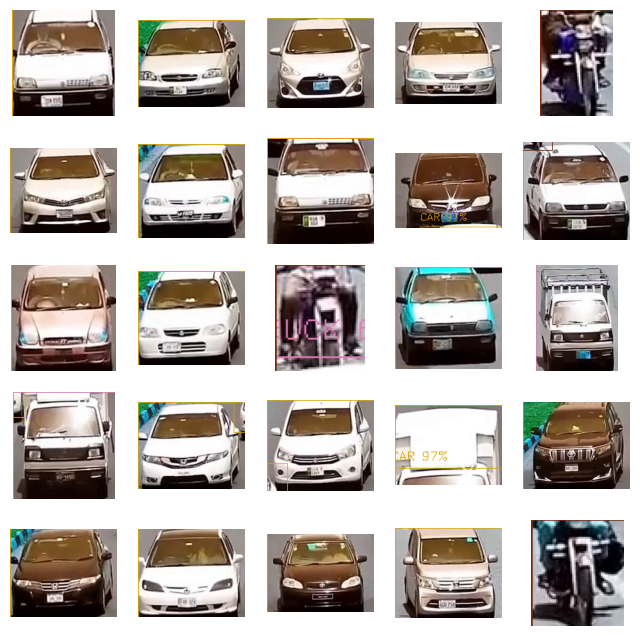

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Assume images is a NumPy array with shape (4, height, width, channels)
# Adjust the dimensions accordingly based on your actual data

# Generate example images for illustration
height, width = 100, 100
images = cars_snapped

# Display the images
fig, axes = plt.subplots(int(len(images)/5), 5, figsize=(8, 8))

for i in range(len(images)):
    ax = axes[i // 5, i % 5]
    ax.imshow(images[i])
    ax.axis('off')  # Turn off axis labels for clarity

plt.show()
